In [1]:
import numpy as np
import polars as pl
from scipy.stats import norm, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from tqdm.notebook import trange, tqdm

In [2]:
def plot_pvalue_ecdf(p_values, title = None, vline = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if title:
            plt.suptitle(title)

    sns.histplot(p_values, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(p_values, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')

    if vline is not None:
        ax2.axvline(vline, color='red', linestyle='--', linewidth=1, label=f'α = {vline}')
        
        ecdf_value = np.mean(np.array(p_values) <= vline)
        
        ax2.axhline(ecdf_value, color='green', linestyle='--', linewidth=1, 
                    label=f'power = {ecdf_value:.3f}')
        
        ax2.legend()
    
    plt.tight_layout()

# Бинарная метрика

## Z-test

### Размер выборки

In [3]:
def sample_size_proportions(
    p_control: float,
    p_treatment: float,
    alpha: float = 0.05,
    power: float = 0.8,
    ratio: float = 0.5,
):
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    var_term = (
        p_control * (1 - p_control) / (1 - ratio)
        + p_treatment * (1 - p_treatment) / ratio
    )
    delta = p_treatment - p_control
    n_total = ((z_alpha + z_beta) ** 2 * var_term) / (delta ** 2)
    n_total = int(np.ceil(n_total))
    n_treatment = int(np.ceil(n_total * ratio))
    n_control = n_total - n_treatment

    return n_control, n_treatment, n_total

#### Зависимость размера выборки от ratio

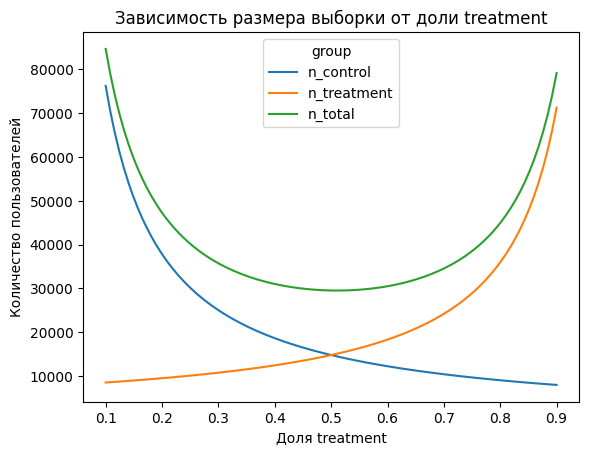

In [4]:
n_controls = []
n_treatments = []
n_totals = []
ratios = []
for ratio in np.linspace(0.1, 0.9, 100):
    n_control, n_treatment, n_total = sample_size_proportions(0.1, 0.11, ratio=ratio)
    n_controls.append(n_control)
    n_treatments.append(n_treatment)
    n_totals.append(n_total)
    ratios.append(ratio)

df = pl.DataFrame({
    "ratio_treatment": ratios,
    "n_control": n_controls,
    "n_treatment": n_treatments,
    "n_total": n_totals
})

df_melt = df.unpivot(
    on=["n_control", "n_treatment", "n_total"],
    index=["ratio_treatment"],
    variable_name="group",
    value_name="sample_size"
)

sns.lineplot(data=df_melt, x="ratio_treatment", y="sample_size", hue="group")
plt.xlabel("Доля treatment")
plt.ylabel("Количество пользователей")
plt.title("Зависимость размера выборки от доли treatment")
plt.show()

#### Зависимость размера выборки от базовой конверсии

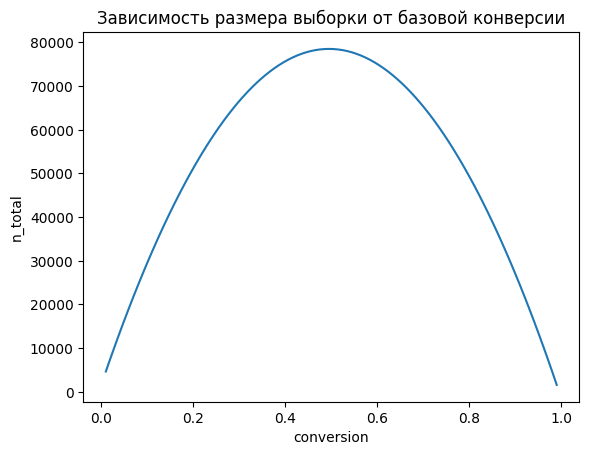

In [5]:
n_totals = []
conversions = []
for p in np.linspace(0.01, 0.99, 100):
    _, _, n_total = sample_size_proportions(p, p+0.01)
    n_totals.append(n_total)
    conversions.append(p)

df = pl.DataFrame({
    "conversion": conversions,
    "n_total": n_totals
})

df_melt = df.unpivot(
    on=["n_total"],
    index=["conversion"],
    variable_name="group",
    value_name="sample_size"
)

sns.lineplot(data=df_melt, x="conversion", y="sample_size")
plt.xlabel("conversion")
plt.ylabel("n_total")
plt.title("Зависимость размера выборки от базовой конверсии")
plt.show()

#### Зависимость размера выборки от размера эффекта

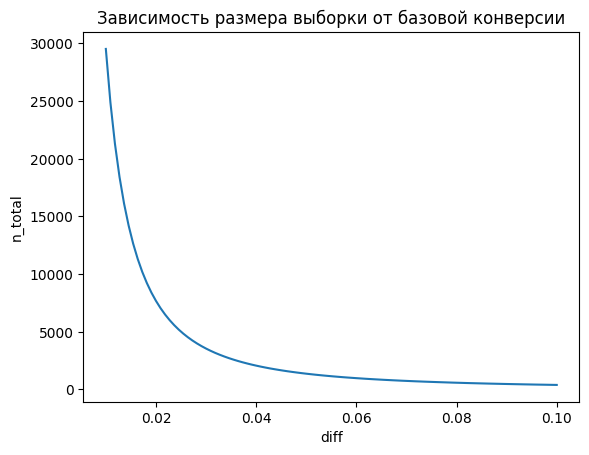

In [6]:
n_totals = []
diffs = []
for diff in np.linspace(0.01, 0.1, 100):
    _, _, n_total = sample_size_proportions(0.1, 0.1+diff)
    n_totals.append(n_total)
    diffs.append(diff)

df = pl.DataFrame({
    "diff": diffs,
    "n_total": n_totals
})

df_melt = df.unpivot(
    on=["n_total"],
    index=["diff"],
    variable_name="group",
    value_name="sample_size"
)

sns.lineplot(data=df_melt, x="diff", y="sample_size")
plt.xlabel("diff")
plt.ylabel("n_total")
plt.title("Зависимость размера выборки от базовой конверсии")
plt.show()

### Контроль ошибки I рода

  0%|          | 0/10000 [00:00<?, ?it/s]

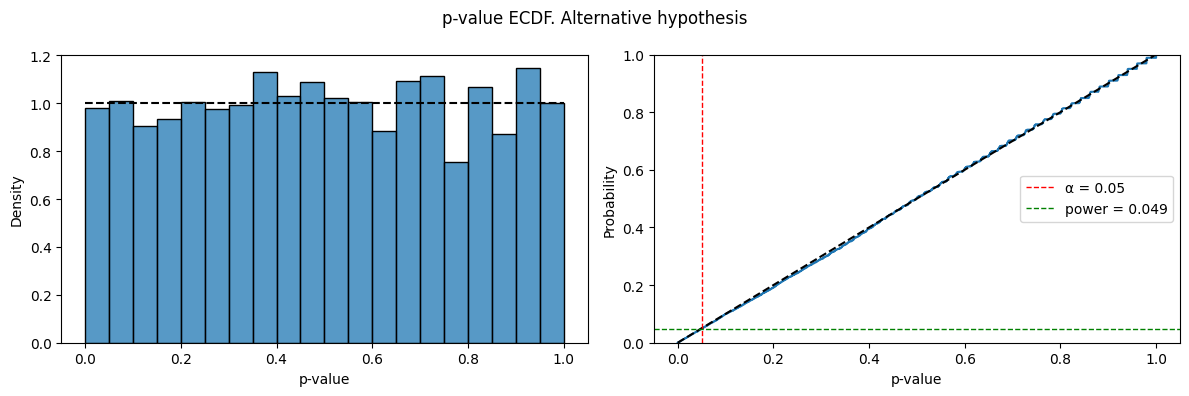

In [7]:
p_control = 0.2
alpha = 0.05
power = 0.8
n_users = 10000
ratio = 0.5

p_values = []
for _ in trange(10000):
    n_control = int(np.ceil(n_users * (1 - ratio)))
    n_treatment = n_users - n_control
    
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_control, n_treatment)
    
    count = np.array([control.sum(), treatment.sum()])
    nobs  = np.array([n_control, n_treatment])

    _, p_value = proportions_ztest(count, nobs)
    p_values.append(p_value)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis', 0.05)

### Контроль ошибки II рода

  0%|          | 0/10000 [00:00<?, ?it/s]

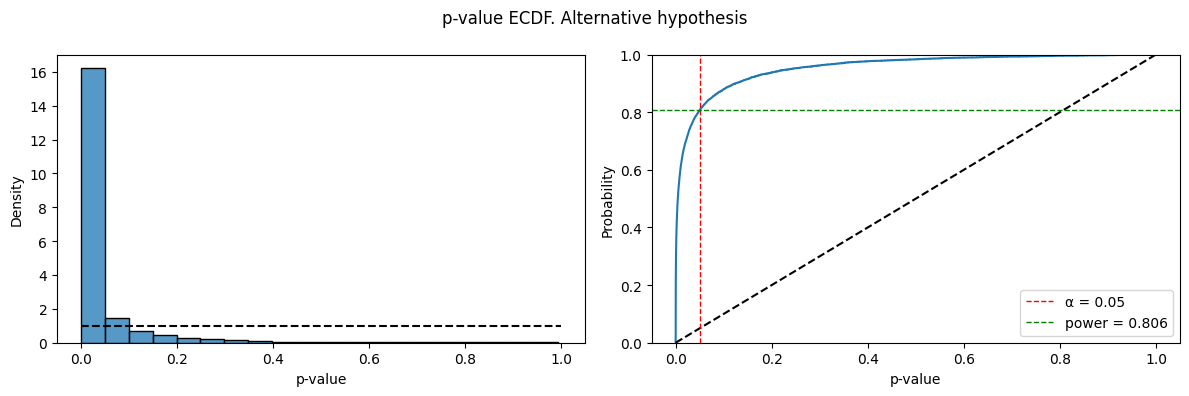

In [8]:
p_control = 0.2
p_treatment = 0.21
alpha = 0.05
power = 0.8
ratio = 0.1

n_control, n_treatment, total_n = sample_size_proportions(p_control, p_treatment, alpha, power, ratio)

p_values = []
for _ in trange(10000):
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_treatment, n_treatment)
    
    count = np.array([control.sum(), treatment.sum()])
    nobs  = np.array([n_control, n_treatment])

    _, p_value = proportions_ztest(count, nobs)
    p_values.append(p_value)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis', 0.05)

## T-test

### Контроль ошибки I рода

  0%|          | 0/10000 [00:00<?, ?it/s]

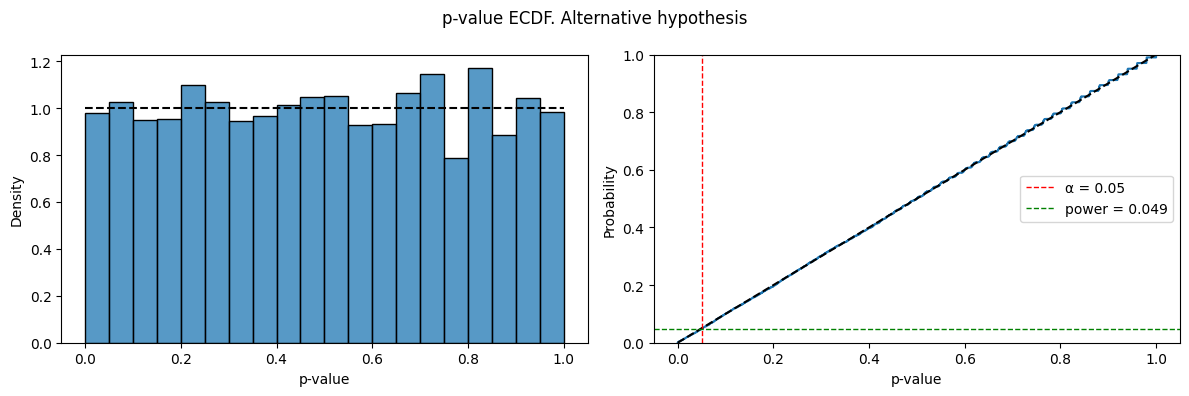

In [9]:
p_control = 0.2
alpha = 0.05
power = 0.8
n_users = 10000
ratio = 0.5

p_values = []
for _ in trange(10000):
    n_control = int(np.ceil(n_users * (1 - ratio)))
    n_treatment = n_users - n_control
    
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_control, n_treatment)

    _, p_value = ttest_ind(control, treatment)
    p_values.append(p_value)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis', 0.05)

### Контроль ошибки II рода

  0%|          | 0/10000 [00:00<?, ?it/s]

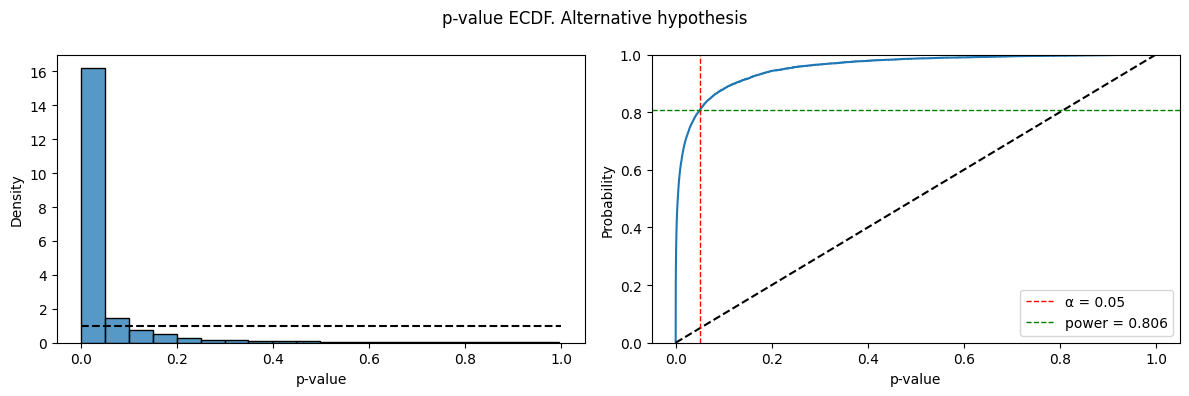

In [11]:
p_control = 0.2
p_treatment = 0.21
alpha = 0.05
power = 0.8
ratio = 0.1

n_control, n_treatment, total_n = sample_size_proportions(p_control, p_treatment, alpha, power, ratio)

p_values = []
for _ in trange(10000):
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_treatment, n_treatment)

    _, p_value = ttest_ind(control, treatment)
    p_values.append(p_value)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis', 0.05)

### Сравнение c z-test

#### При n_total=100

  0%|          | 0/10000 [00:00<?, ?it/s]

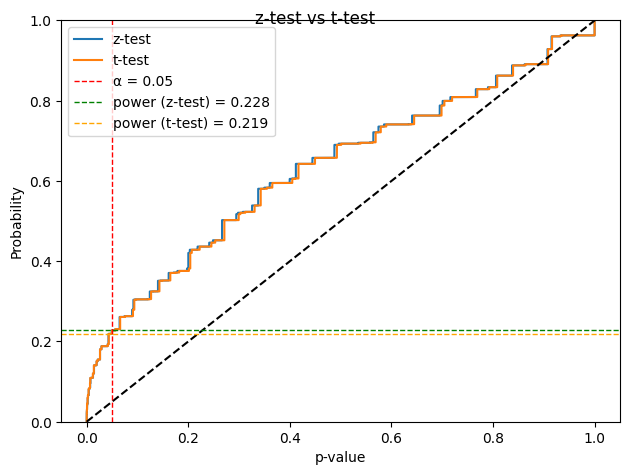

In [13]:
p_control = 0.1
p_treatment = 0.2
alpha = 0.05
power = 0.8
ratio = 0.1
n_total = 100

n_control = int(np.ceil(n_total * (1 - ratio)))
n_treatment = n_total - n_control

ztest_pvalues = []
ttest_pvalues = []
for _ in trange(10000):
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_treatment, n_treatment)

    count = np.array([control.sum(), treatment.sum()])
    nobs  = np.array([n_control, n_treatment])

    _, ztest_p_value = proportions_ztest(count, nobs)
    _, ttest_p_value = ttest_ind(control, treatment)
    ztest_pvalues.append(ztest_p_value)
    ttest_pvalues.append(ttest_p_value)



ax = sns.ecdfplot(ztest_pvalues, label='z-test')
sns.ecdfplot(ttest_pvalues, label='t-test')
ax.plot([0,1],[0,1], 'k--')
ax.set(xlabel='p-value', ylabel='Probability')

ax.axvline(alpha, color='red', linestyle='--', linewidth=1, label=f'α = {alpha}')

ecdf_value_1 = np.mean(np.array(ztest_pvalues) <= alpha)
ecdf_value_2 = np.mean(np.array(ttest_pvalues) <= alpha)

ax.axhline(ecdf_value_1, color='green', linestyle='--', linewidth=1,
            label=f'power (z-test) = {ecdf_value_1:.3f}')
ax.axhline(ecdf_value_2, color='orange', linestyle='--', linewidth=1,
            label=f'power (t-test) = {ecdf_value_2:.3f}')

ax.legend()
plt.tight_layout()
plt.suptitle("z-test vs t-test")
plt.show()

#### При n_total=1000

  0%|          | 0/10000 [00:00<?, ?it/s]

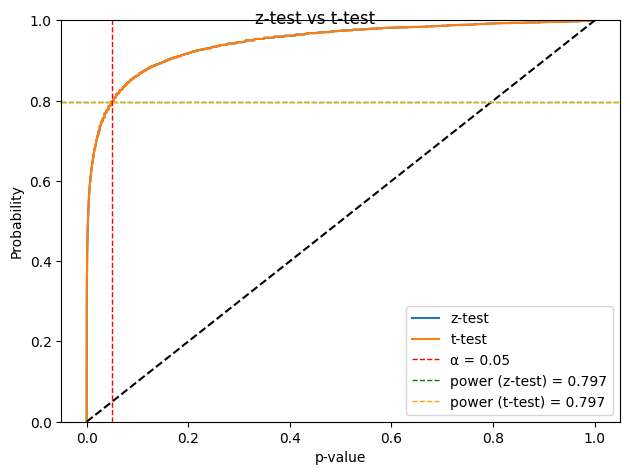

In [14]:
p_control = 0.1
p_treatment = 0.2
alpha = 0.05
power = 0.8
ratio = 0.1
n_total = 1000

n_control = int(np.ceil(n_total * (1 - ratio)))
n_treatment = n_total - n_control

ztest_pvalues = []
ttest_pvalues = []
for _ in trange(10000):
    control = np.random.binomial(1, p_control, n_control)
    treatment = np.random.binomial(1, p_treatment, n_treatment)

    count = np.array([control.sum(), treatment.sum()])
    nobs  = np.array([n_control, n_treatment])

    _, ztest_p_value = proportions_ztest(count, nobs)
    _, ttest_p_value = ttest_ind(control, treatment)
    ztest_pvalues.append(ztest_p_value)
    ttest_pvalues.append(ttest_p_value)

ax = sns.ecdfplot(ztest_pvalues, label='z-test')
sns.ecdfplot(ttest_pvalues, label='t-test')
ax.plot([0,1],[0,1], 'k--')
ax.set(xlabel='p-value', ylabel='Probability')

ax.axvline(alpha, color='red', linestyle='--', linewidth=1, label=f'α = {alpha}')

ecdf_value_1 = np.mean(np.array(ztest_pvalues) <= alpha)
ecdf_value_2 = np.mean(np.array(ttest_pvalues) <= alpha)

ax.axhline(ecdf_value_1, color='green', linestyle='--', linewidth=1,
            label=f'power (z-test) = {ecdf_value_1:.3f}')
ax.axhline(ecdf_value_2, color='orange', linestyle='--', linewidth=1,
            label=f'power (t-test) = {ecdf_value_2:.3f}')

ax.legend()
plt.tight_layout()
plt.suptitle("z-test vs t-test")
plt.show()